In [113]:
import os
import json
import numpy as np
import mne
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [100]:
# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Enable CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda(verbose=False)  # Set to True for debugging

# Load Data

In [101]:
# def load_eeg_data(file_path):
#     """Load EEG data from EEGLAB file"""
#     try:
#         raw = mne.io.read_raw_eeglab(file_path)
#         return raw.get_data()
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# class EEGRFDataset:
#     """
#     Dataset handler for EEG data to be used with Random Forest models.
#     Loads and preprocesses EEG data from files.
#     """

#     def __init__(self, data_dir, data_info=None, scaler=None):
#         """
#         Initialize the dataset handler.

#         Args:
#             data_dir (str): Directory containing the EEG data files
#             data_info (list): List of dictionaries containing file information
#                              (if None, will try to load from labels.json)
#             scaler (StandardScaler): Pre-fitted scaler for feature normalization
#                                     (if None, a new one will be created and fitted)
#         """
#         self.data_dir = data_dir

#         # Load data info if not provided
#         if data_info is None:
#             with open(os.path.join(data_dir, 'labels.json'), 'r') as f:
#                 self.data_info = json.load(f)
#         else:
#             self.data_info = data_info

#         self.scaler = scaler

#         # Generate data and labels lists
#         self.data = [d['file_name'] for d in self.data_info]
#         self.labels = [0 if d['label'] == 'A' else 1 if d['label'] == 'C' else 2 for d in self.data_info]

#     def load_data(self, data_type=None):
#         """
#         Load and preprocess the EEG data.

#         Args:
#             data_type (str, optional): Type of data to load (e.g., 'train', 'test_cross', 'test_within')
#                                       If None, all data will be loaded.

#         Returns:
#             tuple: (X, y) where X is the feature matrix and y contains the labels
#         """
#         X = []
#         y = []

#         # Filter by data type if specified
#         if data_type is not None:
#             filtered_info = [d for d in self.data_info if d['type'] == data_type]
#         else:
#             filtered_info = self.data_info

#         print(f"Loading {len(filtered_info)} EEG samples for {data_type}...")

#         # Load each EEG file
#         for item in filtered_info:
#             file_path = os.path.join(self.data_dir, item['file_name'])
#             label = 0 if item['label'] == 'A' else 1 if item['label'] == 'C' else 2

#             # Load the EEG data from the file
#             eeg_data = load_eeg_data(file_path)

#             if eeg_data is not None:
#                 # Preprocess EEG data for Random Forest
#                 features = self._preprocess_eeg(eeg_data)

#                 X.append(features)
#                 y.append(label)

#         # Convert lists to numpy arrays
#         X = np.array(X)
#         y = np.array(y)

#         if len(X) == 0:
#             raise ValueError(f"No valid data loaded for {data_type}. Please check file paths and data format.")

#         # Create and fit scaler if not provided
#         if self.scaler is None:
#             self.scaler = StandardScaler()
#             X = self.scaler.fit_transform(X)
#         else:
#             X = self.scaler.transform(X)

#         return X, y

#     def _preprocess_eeg(self, eeg_data):
#         """
#         Preprocess the EEG data for Random Forest input.

#         Args:
#             eeg_data (numpy.ndarray): Raw EEG data

#         Returns:
#             numpy.ndarray: Preprocessed features
#         """
#         # Assuming eeg_data shape is (channels, samples) or (samples, channels)
#         # If data is (samples, channels), transpose it
#         if eeg_data.shape[0] > eeg_data.shape[1]:
#             eeg_data = eeg_data.T

#         num_channels = eeg_data.shape[0]

#         # Feature extraction
#         features = []

#         # Time domain and frequency domain features for Random Forest
#         for channel in range(num_channels):
#             channel_data = eeg_data[channel, :]

#             # Time domain features
#             features.extend([
#                 np.mean(channel_data),
#                 np.std(channel_data),
#                 np.max(channel_data),
#                 np.min(channel_data),
#                 np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
#             ])

#             # Frequency domain features
#             fft_data = np.abs(np.fft.rfft(channel_data))
#             # Normalized frequency band powers
#             total_power = np.sum(fft_data)
#             features.extend([
#                 np.sum(fft_data[:5]) / total_power,  # Delta
#                 np.sum(fft_data[5:12]) / total_power,  # Theta
#                 np.sum(fft_data[12:30]) / total_power,  # Alpha
#                 np.sum(fft_data[30:80]) / total_power,  # Beta
#                 np.sum(fft_data[80:]) / total_power  # Gamma
#             ])

#         return np.array(features)

In [102]:
# class EEGRFDataset:
#     """
#     Dataset handler for 4D EEG data to be used with Random Forest models.
#     Loads EEG data from .npy files, preprocesses it by extracting features
#     from windows and averaging them, and prepares it for model training/testing.
#     """

#     def __init__(self, data_dir, data_info=None, scaler=None):
#         """
#         Initialize the dataset handler.

#         Args:
#             data_dir (str): Directory containing the EEG data (.npy) files and labels.json.
#             data_info (list, optional): List of dictionaries containing file information.
#                                         If None, attempts to load from 'labels.json' in data_dir.
#                                         Each dictionary should have 'file_name', 'label', and 'type'.
#             scaler (StandardScaler, optional): Pre-fitted scaler for feature normalization.
#                                                If None, a new one will be created and fitted during load_data.
#         """
#         self.data_dir = data_dir
#         self.scaler = scaler
#         self.data_info = data_info

#         # Load data info from labels.json if not provided
#         if self.data_info is None:
#             labels_path = os.path.join(self.data_dir, 'labels.json')
#             if os.path.exists(labels_path):
#                 try:
#                     with open(labels_path, 'r') as f:
#                         self.data_info = json.load(f)
#                 except Exception as e:
#                     raise FileNotFoundError(f"Error loading {labels_path}: {e}")
#             else:
#                 raise FileNotFoundError(f"labels.json not found in {self.data_dir}")

#         if not isinstance(self.data_info, list):
#              raise ValueError("data_info (or content of labels.json) must be a list of dictionaries.")

#     def _preprocess_eeg_3d(self, eeg_data_3d):
#         """
#         Preprocess 3D EEG data (one subject's windows) for Random Forest input
#         by extracting features from each window and computing the average features across all windows.

#         Args:
#             eeg_data_3d (numpy.ndarray): 3D EEG data with shape (windows, channels, samples)
#                                          or (windows, samples, channels).

#         Returns:
#             numpy.ndarray: 1D array of averaged features across all windows for one subject.
#         """
#         # Check if input is empty or invalid
#         if eeg_data_3d is None or eeg_data_3d.size == 0:
#             print("Warning: Empty or invalid 3D EEG data encountered.")
#             # Return an array of zeros or handle as appropriate
#             # The number of expected features needs to be known or estimated.
#             # For now, returning None, to be handled in the calling function.
#             # A better approach might be to determine the expected feature vector length.
#             return None # Or np.zeros(EXPECTED_FEATURE_LENGTH)

#         # Ensure it's a 3D array
#         if eeg_data_3d.ndim != 3:
#              raise ValueError(f"Expected 3D EEG data, but got {eeg_data_3d.ndim} dimensions.")

#         num_windows, dim1, dim2 = eeg_data_3d.shape

#         # Initialize array to store features for each window
#         all_window_features = []

#         # Process each window
#         for window_idx in range(num_windows):
#             # Extract the 2D data for this window
#             window_data = eeg_data_3d[window_idx, :, :]

#             # Determine if channels or samples is the larger dimension
#             # Assuming shape is (channels, samples) or (samples, channels)
#             # If samples dimension comes first, transpose it to (channels, samples)
#             if dim1 > dim2: # Samples dimension is likely dim1
#                 window_data = window_data.T # Transpose to (channels, samples)
#                 num_channels = dim2
#             else: # Channels dimension is likely dim1
#                 num_channels = dim1

#             # Check if window_data is valid after potential transpose
#             if window_data.shape[0] != num_channels:
#                  raise ValueError(f"Channel dimension mismatch after transpose check. Expected {num_channels}, got {window_data.shape[0]}")


#             # Feature extraction for this window
#             window_features = []

#             # Time domain and frequency domain features for Random Forest
#             for channel in range(num_channels):
#                 channel_data = window_data[channel, :]

#                 # Check for empty or constant channel data
#                 if channel_data.size == 0 or np.all(channel_data == channel_data[0]):
#                    # Append zeros or NaNs for this channel's features if data is constant/empty
#                    window_features.extend([0] * 10) # 5 time-domain + 5 frequency-domain
#                    continue # Skip FFT calculation for this channel


#                 # Time domain features
#                 window_features.extend([
#                     np.mean(channel_data),
#                     np.std(channel_data),
#                     np.max(channel_data),
#                     np.min(channel_data),
#                     np.percentile(channel_data, 75) - np.percentile(channel_data, 25) # IQR
#                 ])

#                 # Frequency domain features
#                 # Ensure channel_data is 1D
#                 if channel_data.ndim > 1:
#                     channel_data = channel_data.flatten()

#                 fft_data = np.abs(np.fft.rfft(channel_data))
#                 total_power = np.sum(fft_data)

#                 # Normalized frequency band powers
#                 if total_power > 1e-9: # Avoid division by zero or near-zero
#                     # Define frequency bins (adjust based on sampling rate if known, assuming standard ranges here)
#                     # These indices might need adjustment based on actual sampling frequency and FFT length.
#                     # Example: If Fs=250Hz, N=len(channel_data), freq_res = Fs/N
#                     # Delta (0-4 Hz), Theta (4-8 Hz), Alpha (8-13 Hz), Beta (13-30 Hz), Gamma (30+ Hz)
#                     # The indices below are placeholders and should be calculated based on Fs and FFT length.
#                     # For simplicity, using fixed indices as in the original snippet.
#                     delta_power = np.sum(fft_data[:5]) / total_power
#                     theta_power = np.sum(fft_data[5:12]) / total_power
#                     alpha_power = np.sum(fft_data[12:30]) / total_power
#                     beta_power = np.sum(fft_data[30:80]) / total_power
#                     gamma_power = np.sum(fft_data[80:]) / total_power
#                     window_features.extend([
#                         delta_power, theta_power, alpha_power, beta_power, gamma_power
#                     ])
#                 else:
#                     # Append zeros if total power is negligible
#                     window_features.extend([0, 0, 0, 0, 0])

#             # Append the features computed for this window
#             all_window_features.append(window_features)

#         # Check if any features were extracted
#         if not all_window_features:
#             print("Warning: No features extracted for this 3D data block.")
#             # Determine expected feature length based on num_channels * (5 time + 5 freq)
#             # This requires knowing num_channels reliably.
#             # Returning None for now.
#             return None # Or np.zeros(EXPECTED_FEATURE_LENGTH)


#         # Convert list of lists to numpy array for easier computation
#         all_window_features = np.array(all_window_features)

#         # Compute average features across all windows (axis=0)
#         # Use nanmean to handle potential NaNs if any features were NaN
#         avg_features = np.nanmean(all_window_features, axis=0)

#         # Check if avg_features contains NaNs (e.g., if all windows had NaN for a feature)
#         if np.isnan(avg_features).any():
#             print("Warning: NaNs found in averaged features. Replacing NaNs with 0.")
#             avg_features = np.nan_to_num(avg_features) # Replace NaN with zero

#         return avg_features

#     def _preprocess_dataset(self, data_4d):
#         """
#         Process 4D EEG data by extracting averaged features for each subject.

#         Args:
#             data_4d (numpy.ndarray): 4D EEG data with shape (subjects, windows, channels, samples)
#                                      or (subjects, windows, samples, channels).

#         Returns:
#             numpy.ndarray: 2D array where each row represents a subject's averaged features.
#                            Shape will be (num_subjects, num_features).
#         """
#          # Ensure it's a 4D array
#         if data_4d.ndim != 4:
#              raise ValueError(f"Expected 4D EEG data, but got {data_4d.ndim} dimensions.")

#         num_subjects = data_4d.shape[0]
#         processed_features_list = []

#         # Process each subject separately
#         for subject_idx in range(num_subjects):
#             # Extract the 3D data for this subject
#             subject_data_3d = data_4d[subject_idx]

#             # Process this subject's 3D data using the 3D preprocessing function
#             subject_features_1d = self._preprocess_eeg_3d(subject_data_3d)

#             # Append the resulting 1D feature vector for the subject
#             if subject_features_1d is not None:
#                 processed_features_list.append(subject_features_1d)
#             else:
#                  # Handle cases where _preprocess_eeg_3d returned None (e.g., empty data)
#                  # Option 1: Skip this subject (might lead to label mismatch if not handled)
#                  # Option 2: Append a vector of zeros/NaNs (requires knowing feature length)
#                  print(f"Warning: Skipping subject {subject_idx} due to preprocessing error or empty data.")
#                  # If skipping, ensure labels are also skipped later. This is complex.
#                  # For now, let's assume we need a placeholder if we want to keep the subject count consistent.
#                  # This requires knowing the feature length. Let's assume the first subject determines it.
#                  if processed_features_list:
#                      feature_length = len(processed_features_list[0])
#                      processed_features_list.append(np.zeros(feature_length))
#                  else:
#                      # Cannot determine feature length yet, this case needs careful handling.
#                      # Maybe raise an error or log extensively.
#                      print(f"Error: Cannot determine feature length for placeholder for subject {subject_idx}.")
#                      # As a fallback, appending an empty array might cause issues later.
#                      # Consider raising an error if the first subject fails.
#                      if subject_idx == 0:
#                          raise ValueError("Preprocessing failed for the first subject, cannot determine feature length.")
#                      # If not the first, try to get length from previous subject
#                      try:
#                         feature_length = len(processed_features_list[-1])
#                         processed_features_list.append(np.zeros(feature_length))
#                      except IndexError: # Should not happen if not first subject, but safety check
#                          raise ValueError("Inconsistent state during feature processing.")


#         # Convert list of 1D arrays to a 2D numpy array
#         if not processed_features_list:
#             # Return empty array if no subjects were processed successfully
#             return np.empty((0, 0))

#         return np.array(processed_features_list)


#     def load_data(self, data_type=None):
#         """
#         Load and preprocess the 4D EEG data for a specific data type.

#         Args:
#             data_type (str, optional): Type of data to load (e.g., 'train', 'test').
#                                        Corresponds to the 'type' field in data_info/labels.json.
#                                        If None, all data will be loaded.

#         Returns:
#             tuple: (X, y) where X is the 2D feature matrix (subjects, features)
#                    and y contains the corresponding labels.
#         """
#         X_raw_list = []
#         y_list = []

#         # Filter data_info by data_type if specified
#         if data_type is not None:
#             filtered_info = [d for d in self.data_info if d.get('type') == data_type]
#             if not filtered_info:
#                  print(f"Warning: No data found for type '{data_type}' in data_info.")
#                  return np.empty((0,0)), np.empty((0,)) # Return empty arrays
#         else:
#             filtered_info = self.data_info # Load all data

#         print(f"Loading {len(filtered_info)} EEG samples for type: {data_type if data_type else 'all'}...")

#         # Load each specified EEG file (.npy format expected)
#         for item in filtered_info:
#             file_name = item.get('file_name')
#             label_str = item.get('label') # Expecting 'A', 'C', etc.

#             if not file_name or label_str is None:
#                 print(f"Warning: Skipping item due to missing 'file_name' or 'label': {item}")
#                 continue

#             # Construct file path
#             file_path = os.path.join(self.data_dir, file_name)

#             # Define label mapping (adjust if labels are different)
#             if label_str == 'A':
#                 label = 0
#             elif label_str == 'C':
#                 label = 1
#             # Add more conditions if there are other labels like 'B' etc.
#             # elif label_str == 'B':
#             #     label = 2
#             else:
#                 try:
#                     # Attempt to convert label to integer if it's numerical
#                     label = int(label_str)
#                 except ValueError:
#                     print(f"Warning: Skipping item with unrecognized label '{label_str}' in file {file_name}")
#                     continue # Skip this file if label is not recognized

#             # Load the 4D EEG data from the .npy file
#             try:
#                 # Assuming each .npy file contains the 4D data for ONE subject
#                 # Shape: (windows, channels, samples) or (windows, samples, channels)
#                 # If each file is already 4D (subjects=1, windows, ...), adjust loading
#                 # Current assumption: each file is 3D (windows, channels, samples) for one subject
#                 eeg_data_3d = np.load(file_path)

#                 # Check if data loaded is valid (e.g., not empty)
#                 if eeg_data_3d.size == 0:
#                     print(f"Warning: Loaded empty array from {file_path}. Skipping.")
#                     continue

#                 # Append the loaded 3D data (for one subject) to the list
#                 X_raw_list.append(eeg_data_3d)
#                 y_list.append(label)

#             except FileNotFoundError:
#                 print(f"Error: File not found {file_path}. Skipping.")
#                 continue
#             except Exception as e:
#                 print(f"Error loading or processing {file_path}: {e}. Skipping.")
#                 continue

#         # Check if any data was loaded
#         if not X_raw_list:
#             # Raise error or return empty arrays if no valid data could be loaded
#             # raise ValueError(f"No valid data loaded for type '{data_type}'. Check file paths, data format, and labels.json.")
#             print(f"Warning: No valid data loaded for type '{data_type}'. Returning empty arrays.")
#             return np.empty((0, 0)), np.empty((0,))


#         # Stack the list of 3D arrays into a 4D array (subjects, windows, channels, samples)
#         try:
#             X_raw_4d = np.stack(X_raw_list, axis=0)
#         except ValueError as e:
#             # This might happen if the 3D arrays have inconsistent shapes
#             print(f"Error: Could not stack loaded data into a 4D array. Check shapes of .npy files. Details: {e}")
#              # Provide more details about shapes for debugging
#             for i, arr in enumerate(X_raw_list):
#                 print(f"Shape of loaded data {i} ({filtered_info[i].get('file_name')}): {arr.shape}")
#             raise ValueError("Inconsistent shapes among loaded .npy files.") from e


#         print(f"Raw data loaded with shape: {X_raw_4d.shape}")

#         # Preprocess the entire 4D dataset to get 2D features (subjects, features)
#         print("Preprocessing dataset...")
#         X_processed = self._preprocess_dataset(X_raw_4d)
#         y = np.array(y_list) # Convert labels list to numpy array

#         # Ensure X_processed and y have the same number of subjects
#         if X_processed.shape[0] != len(y):
#             # This might happen if some subjects were skipped during preprocessing
#             # Need a strategy: either filter 'y' accordingly or raise error
#             raise ValueError(f"Mismatch between number of processed feature sets ({X_processed.shape[0]}) and labels ({len(y)}). This might be due to skipping subjects during preprocessing.")


#         print(f"Processed features shape: {X_processed.shape}")

#         # Check if processed features are empty
#         if X_processed.size == 0:
#              raise ValueError(f"Preprocessing resulted in an empty feature set for type '{data_type}'.")


#         # Apply scaling
#         if X_processed.shape[0] > 0: # Only scale if there is data
#              if self.scaler is None:
#                  print("Fitting StandardScaler...")
#                  self.scaler = StandardScaler()
#                  X_scaled = self.scaler.fit_transform(X_processed)
#              else:
#                  print("Transforming data using provided StandardScaler...")
#                  X_scaled = self.scaler.transform(X_processed)
#         else:
#              X_scaled = X_processed # Keep empty array if no data


#         print(f"Finished loading and preprocessing. Final features shape: {X_scaled.shape}")

#         return X_scaled, y

#     def get_scaler(self):
#         """Returns the fitted scaler."""
#         return self.scaler

In [ ]:
# Load subject labels
with open("model-data/Labels_epochs.json", "r") as f:
    subject_labels = json.load(f)

def load_data(directory):
    """
    Loads and returns augmented EEG data (X) and corresponding labels (y) from the specified directory.
    """
    X, y = [], []
    for file in os.listdir(directory):
        if file.endswith(".npy"):
            # Load the features (EEG data)
            X_data = np.load(os.path.join(directory, file))
            # Load corresponding label (subject ID matches file naming convention)
            subject_id = file.split("_")[0]
            label = subject_labels.get(subject_id, None)
            if label is not None:
                X.append(X_data)
                y.append(label)

    return np.array(X), np.array(y)

def preprocess_eeg_3d(eeg_data_3d):
    """
    Preprocess 3D EEG data for Random Forest input by extracting features from each window
    and computing the average features across all windows.
    
    Args:
        eeg_data_3d (numpy.ndarray): 3D EEG data with shape (windows, channels, samples)
                                     or (windows, samples, channels)
    
    Returns:
        numpy.ndarray: Averaged features across all windows
    """
    # Get the dimensions
    A, B, C = eeg_data_3d.shape
    
    # Initialize array to store features for each window
    all_window_features = []
    
    # Process each window
    for window_idx in range(A):
        # Extract the 2D data for this window
        window_data = eeg_data_3d[window_idx, :, :]
        
        # If data is (samples, channels), transpose it
        if B > C:
            window_data = window_data.T
            
        num_channels = window_data.shape[0]
        
        # Feature extraction for this window
        window_features = []
        
        # Time domain and frequency domain features
        for channel in range(num_channels):
            channel_data = window_data[channel, :]
            
            # Time domain features
            window_features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.max(channel_data),
                np.min(channel_data),
                np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
            ])
            
            # Frequency domain features
            fft_data = np.abs(np.fft.rfft(channel_data))
            # Normalized frequency band powers
            total_power = np.sum(fft_data)
            if total_power > 0:  # Avoid division by zero
                window_features.extend([
                    np.sum(fft_data[:5]) / total_power,  # Delta
                    np.sum(fft_data[5:12]) / total_power,  # Theta
                    np.sum(fft_data[12:30]) / total_power,  # Alpha
                    np.sum(fft_data[30:80]) / total_power,  # Beta
                    np.sum(fft_data[80:]) / total_power  # Gamma
                ])
            else:
                window_features.extend([0, 0, 0, 0, 0])  # Zero power case
                
        all_window_features.append(window_features)
    
    # Convert to numpy array for easier computation
    all_window_features = np.array(all_window_features)
    
    # Compute average features across all windows
    avg_features = np.mean(all_window_features, axis=0)
    
    return avg_features

def preprocess_dataset(data_4d):
    """
    Process 4D EEG data by extracting features for each subject.
    
    Args:
        data_4d (numpy.ndarray): 4D EEG data with shape (subjects, windows, channels, samples)
                                or (subjects, windows, samples, channels)
    
    Returns:
        numpy.ndarray: 2D array where each row represents a subject's features
    """
    num_subjects = data_4d.shape[0]
    processed_features = []
    
    # Process each subject separately
    for subject_idx in range(num_subjects):
        # Extract the 3D data for this subject
        subject_data = data_4d[subject_idx]
        
        # Process this subject's 3D data using our window-processing function
        subject_features = preprocess_eeg_3d(subject_data)
        
        # Add to our collection
        processed_features.append(subject_features)
    
    # Convert to numpy array - shape will be (num_subjects, num_features)
    return np.array(processed_features)


# Models

In [104]:
class EEGRF:
    """
    Random Forest model for EEG classification with hyperparameter optimization.
    """

    def __init__(self, n_estimators=100, max_depth=None, class_weight=None):
        """
        Initialize the Random Forest model.

        Args:
            n_estimators (int): Number of trees in the forest
            max_depth (int or None): The maximum depth of the trees
            class_weight (dict or 'balanced'): Weights associated with classes in the form {class_label: weight}
        """
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42
        )

    def train(self, X_train, y_train):
        """
        Train the Random Forest model.

        Args:
            X_train (numpy.ndarray): Training features
            y_train (numpy.ndarray): Training labels

        Returns:
            EEGRF: Self for method chaining
        """
        print("Training Random Forest model...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_acc:.4f}")

        return self

    def predict(self, X):
        """
        Make predictions with the trained model.

        Args:
            X (numpy.ndarray): Features

        Returns:
            numpy.ndarray: Predictions
        """
        return self.model.predict(X)

In [105]:

class EEGSVM:
    """
    Support Vector Machine model for EEG classification with hyperparameter optimization.
    """

    def __init__(self, C=1.0, kernel='rbf', class_weight=None):
        """
        Initialize the SVM model.

        Args:
            C (float): Regularization parameter
            kernel (str): Kernel type to be used in the algorithm
            class_weight (dict or 'balanced'): Weights associated with classes
        """
        # Initialize the SVC with given hyperparameters
        self.model = SVC(
            C=C,
            kernel=kernel,
            class_weight=class_weight,
            probability=True,
            random_state=42
        )

    def train(self, X_train, y_train):
        """
        Train the SVM model.

        Args:
            X_train (numpy.ndarray): Training features
            y_train (numpy.ndarray): Training labels

        Returns:
            EEGSVM: Self for method chaining
        """
        print("Training SVM model...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_acc:.4f}")

        return self

    def predict(self, X):
        """
        Make predictions with the trained model.

        Args:
            X (numpy.ndarray): Features

        Returns:
            numpy.ndarray: Predictions
        """
        return self.model.predict(X)

In [106]:
class EEGGradientBoost:
    """
    Gradient Boosting model for EEG classification with hyperparameter optimization.
    """

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0):
        """
        Initialize the Gradient Boosting model.

        Args:
            n_estimators (int): Number of boosting stages
            learning_rate (float): Learning rate shrinks the contribution of each tree
            max_depth (int): Maximum depth of the individual regression estimators
            subsample (float): The fraction of samples to be used for fitting the individual base learners
        """
        # Initialize the GradientBoostingClassifier with given hyperparameters
        self.model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            random_state=42
        )

    def train(self, X_train, y_train):
        """
        Train the Gradient Boosting model.

        Args:
            X_train (numpy.ndarray): Training features
            y_train (numpy.ndarray): Training labels

        Returns:
            EEGGradientBoost: Self for method chaining
        """
        print("Training Gradient Boosting model...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"Training accuracy: {train_acc:.4f}")

        return self

    def predict(self, X):
        """
        Make predictions with the trained model.

        Args:
            X (numpy.ndarray): Features

        Returns:
            numpy.ndarray: Predictions
        """
        return self.model.predict(X)

# Evaluation

In [107]:
def evaluate_model(model, X_test, y_test, n_splits=5):
    """
    Evaluate a trained model using k-fold cross-validation.
    
    Args:
        model: Trained model with a predict function
        X_test (numpy.ndarray): Test features
        y_test (numpy.ndarray): Test labels
        n_splits (int): Number of folds
    
    Returns:
        dict: Dictionary with evaluation metrics
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize metrics
    all_confusion = []
    all_accuracy = []
    all_precision = []
    all_recall = []
    all_f1 = []
    
    # If y is one-hot encoded, convert to class labels
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    
    fold_idx = 1
    for train_index, test_index in kf.split(X_test):
        X_fold = X_test[test_index]
        y_fold = y_test[test_index]
        
        # Make predictions
        y_pred = model.predict(X_fold)
        
        # Calculate metrics
        cm = confusion_matrix(y_fold, y_pred)
        acc = accuracy_score(y_fold, y_pred)
        
        # Handle binary vs multi-class
        if n_classes <= 2:
            prec = precision_score(y_fold, y_pred)
            rec = recall_score(y_fold, y_pred)
            f1 = f1_score(y_fold, y_pred)
        else:
            prec = precision_score(y_fold, y_pred, average='weighted')
            rec = recall_score(y_fold, y_pred, average='weighted')
            f1 = f1_score(y_fold, y_pred, average='weighted')
        
        # Store metrics
        all_confusion.append(cm)
        all_accuracy.append(acc)
        all_precision.append(prec)
        all_recall.append(rec)
        all_f1.append(f1)
        
        print(f"Fold {fold_idx} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, "
              f"Recall: {rec:.4f}, F1: {f1:.4f}")
        fold_idx += 1
    
    # Calculate average metrics
    avg_cm = np.mean(all_confusion, axis=0)
    avg_acc = np.mean(all_accuracy)
    avg_prec = np.mean(all_precision)
    avg_rec = np.mean(all_recall)
    avg_f1 = np.mean(all_f1)
    
    # Print average metrics
    print("\nAverage Metrics:")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    
    # Plot average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Average Confusion Matrix')
    plt.show()
    
    # Return results
    return {
        'confusion_matrix': avg_cm,
        'accuracy': avg_acc,
        'precision': avg_prec,
        'recall': avg_rec,
        'f1': avg_f1
    }

# Running

In [108]:
# data_dir = r"model-data\epochs-numpy-corrected"

# # Create dataset handler
# dataset_1 = EEGRFDataset(data_dir)
# # Load training data
# X_train, y_train = dataset_1.load_data(data_type='train')
# print(f"Loaded training data: {X_train.shape} features, {len(y_train)} labels")

In [109]:
X_train, y_train = load_data("model-data/epochs-numpy-corrected/train")
X_test, y_test = load_data("model-data/epochs-numpy-corrected/test")

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Apply the processing to both train and test datasets
X_train = preprocess_dataset(X_train)
X_test = preprocess_dataset(X_test)

# Print the shapes to confirm
print(f"Processed train_data shape: {X_train.shape}")
print(f"Processed test_data shape: {X_test.shape}")

(240, 476, 19, 190) (104, 476, 19, 190)
(240,) (104,)
Processed train_data shape: (240, 190)
Processed test_data shape: (104, 190)


In [114]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

Training Random Forest model...
Training accuracy: 1.0000
Fold 1 - Accuracy: 0.7143, Precision: 0.7347, Recall: 0.7143, F1: 0.7213
Fold 2 - Accuracy: 0.7143, Precision: 0.7687, Recall: 0.7143, F1: 0.7222
Fold 3 - Accuracy: 0.8571, Precision: 0.9048, Recall: 0.8571, F1: 0.8621
Fold 4 - Accuracy: 0.6667, Precision: 0.9000, Recall: 0.6667, F1: 0.7070
Fold 5 - Accuracy: 0.8000, Precision: 0.8562, Recall: 0.8000, F1: 0.7969

Average Metrics:
Accuracy: 0.7505
Precision: 0.8329
Recall: 0.7505
F1 Score: 0.7619


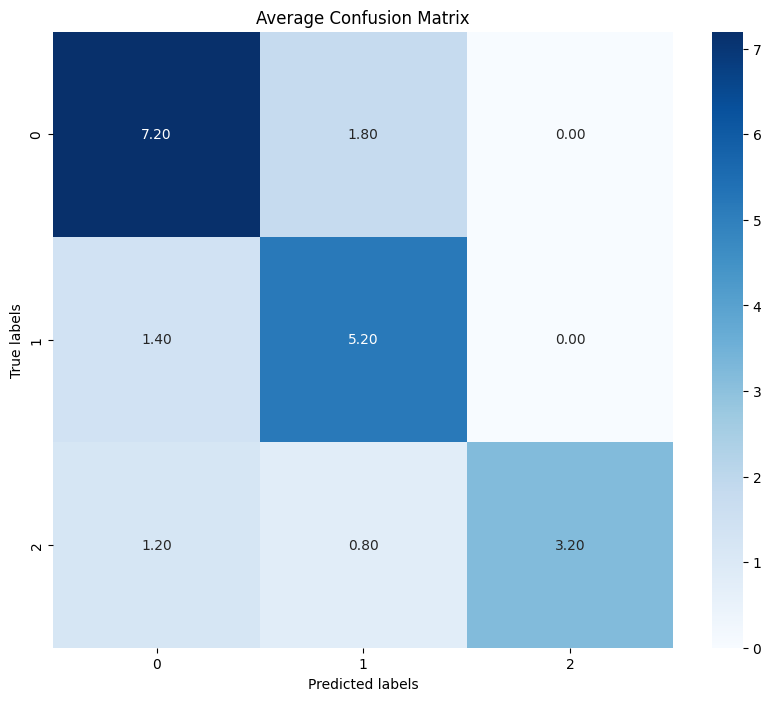


Final Evaluation Results:
Average Accuracy: 0.7505
Average Precision: 0.8329
Average Recall: 0.7505
Average F1 Score: 0.7619


In [115]:
# Initialize and train the model
rf_model = EEGRF(n_estimators=100, max_depth=None, class_weight='balanced')
rf_model.train(X_train, y_train)

results = evaluate_model(rf_model, X_test, y_test, n_splits=5)
print(f"\nFinal Evaluation Results:")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")

Training SVM model...
Training accuracy: 0.3000
Fold 1 - Accuracy: 0.2857, Precision: 0.1464, Recall: 0.2857, F1: 0.1818
Fold 2 - Accuracy: 0.0952, Precision: 0.0254, Recall: 0.0952, F1: 0.0401
Fold 3 - Accuracy: 0.1429, Precision: 0.0690, Recall: 0.1429, F1: 0.0731
Fold 4 - Accuracy: 0.3810, Precision: 0.3743, Recall: 0.3810, F1: 0.3672
Fold 5 - Accuracy: 0.2000, Precision: 0.0933, Recall: 0.2000, F1: 0.1273

Average Metrics:
Accuracy: 0.2210
Precision: 0.1417
Recall: 0.2210
F1 Score: 0.1579


C:\Users\27298\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\27298\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\27298\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

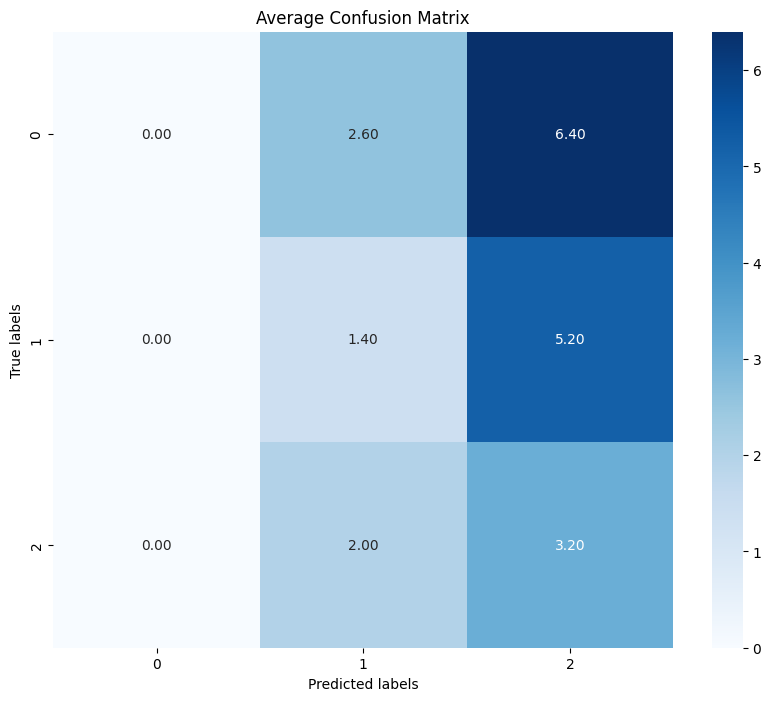


Final Evaluation Results:
Average Accuracy: 0.2210
Average Precision: 0.1417
Average Recall: 0.2210
Average F1 Score: 0.1579


In [ ]:
svm_model = EEGSVM(C=1.0, kernel='rbf', class_weight='balanced')
svm_model.train(X_train, y_train)

results = evaluate_model(svm_model, X_test, y_test, n_splits=5)
print(f"\nFinal Evaluation Results:")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")

Training Gradient Boosting model...
Training accuracy: 1.0000
Fold 1 - Accuracy: 0.8095, Precision: 0.8316, Recall: 0.8095, F1: 0.8112
Fold 2 - Accuracy: 0.6667, Precision: 0.7211, Recall: 0.6667, F1: 0.6746
Fold 3 - Accuracy: 0.9048, Precision: 0.9286, Recall: 0.9048, F1: 0.9076
Fold 4 - Accuracy: 0.6667, Precision: 0.8466, Recall: 0.6667, F1: 0.6905
Fold 5 - Accuracy: 0.8000, Precision: 0.8397, Recall: 0.8000, F1: 0.7923

Average Metrics:
Accuracy: 0.7695
Precision: 0.8335
Recall: 0.7695
F1 Score: 0.7752


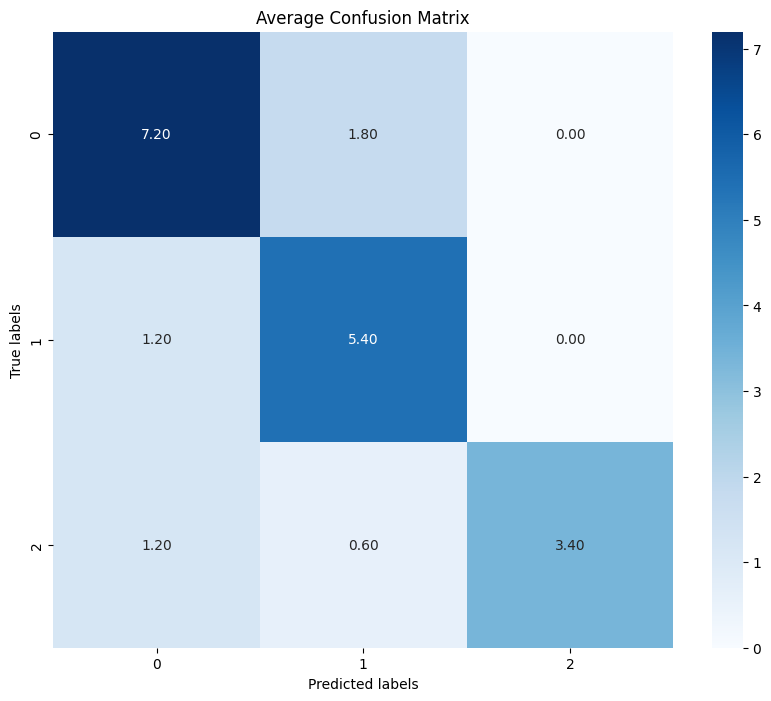


Final Evaluation Results:
Average Accuracy: 0.7695
Average Precision: 0.8335
Average Recall: 0.7695
Average F1 Score: 0.7752


In [117]:
gb_model = EEGGradientBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0
)
gb_model.train(X_train, y_train)

results = evaluate_model(gb_model, X_test, y_test, n_splits=5)
print(f"\nFinal Evaluation Results:")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")